In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

In [13]:
from utils import core_models
from utils.model_utils import fix_seeds
from utils.datasets import CPDDatasets
from utils.cpd_models import CPDModel
from utils.sgld import CPDModelCustomNoisyAdam
from utils.metrics import evaluation_pipeline, write_metrics_to_file

import math
import yaml

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datetime import datetime

#from torch_sgld import SGLD, CosineLR

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler

import pytorch_lightning as pl

from pytorch_lightning.loggers import CometLogger
#from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
SEED = 42
fix_seeds(SEED)

model_type = "seq2seq"

experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1

args_config["learning"]["epochs"] = 100

In [4]:
train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
train_dataset[0][0].shape

(20, 28)

# SGLD (Custom)

In [5]:
args_config["learning"]["lr"] = 1e-3
args_config["learning"]["temperature"] = 0.001

# for ABAnnealingLR
args_config["learning"]["final_lr"] = 1e-4
args_config["learning"]["gamma"] = 0.5
args_config["learning"]["T_max"] = 50000

threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

core_model = core_models.BaseRnn(
    input_size=args_config["model"]["input_size"],
    hidden_dim=args_config["model"]["hidden_dim"],
    n_layers=args_config["model"]["n_layers"],
    drop_prob=args_config["model"]["drop_prob"],
    layer_norm=args_config["model"]["layer_norm"]
)

bce_model_custom_noisy_adam = CPDModelCustomNoisyAdam(
    loss_type="bce",
    args=args_config,
    model=core_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

In [6]:
bce_model_custom_noisy_adam.load_state_dict(torch.load(
    "saved_models/bce/human_activity/sgld_adam/human_activity_loss_type_bcesgld_adam__model_num_5.pth"
))

<All keys matched successfully>

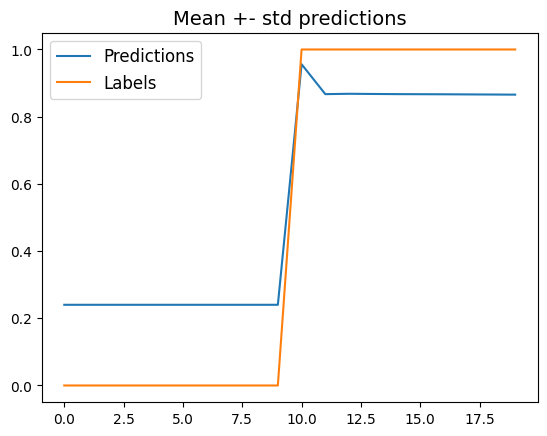

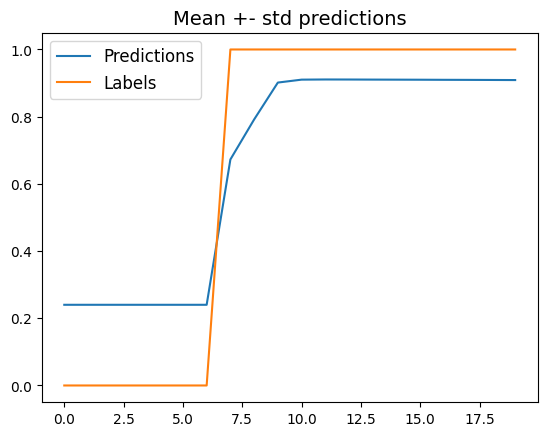

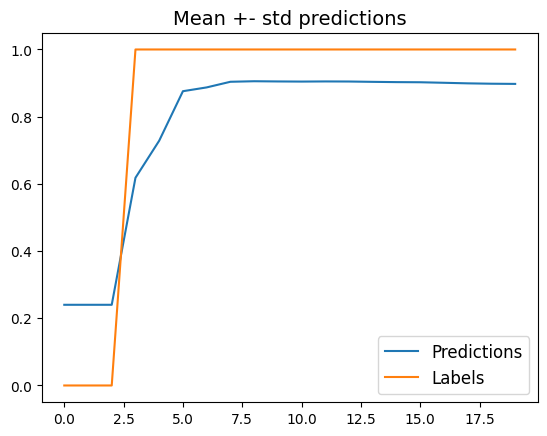

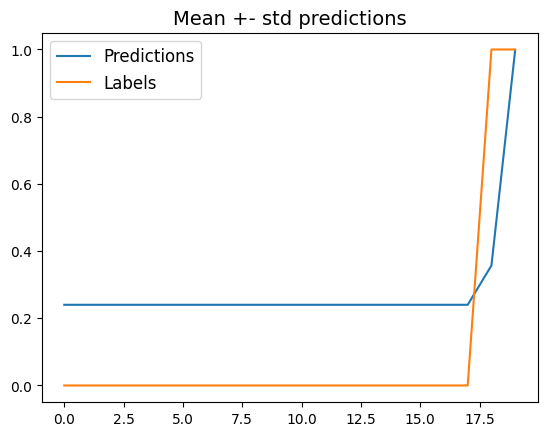

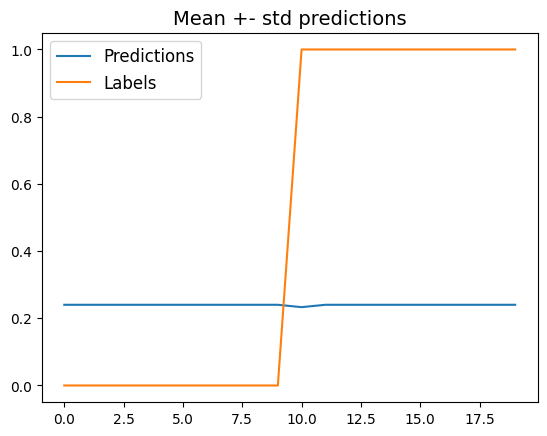

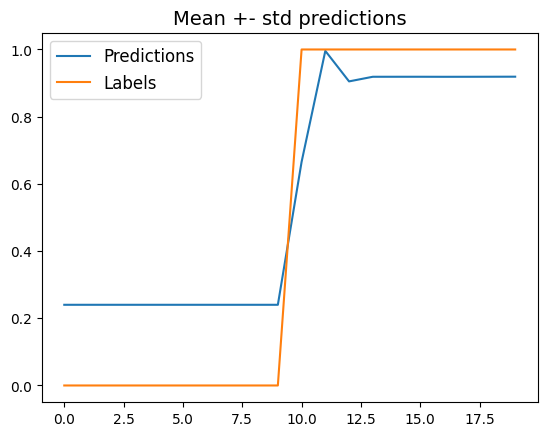

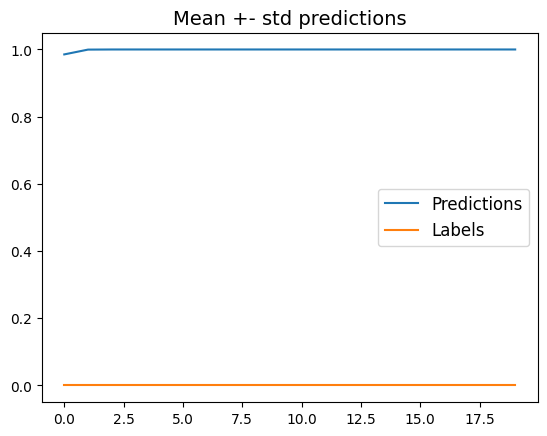

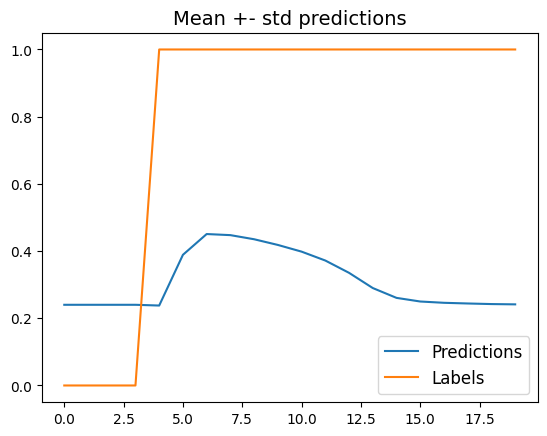

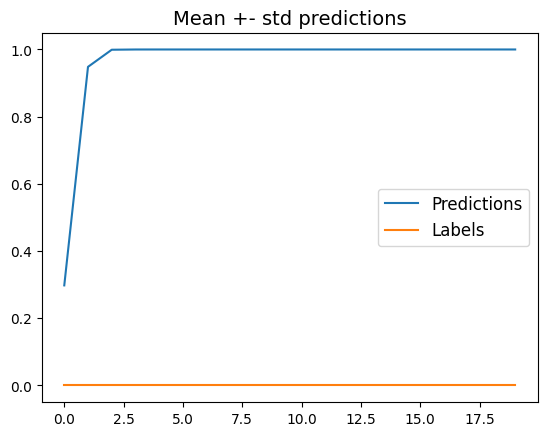

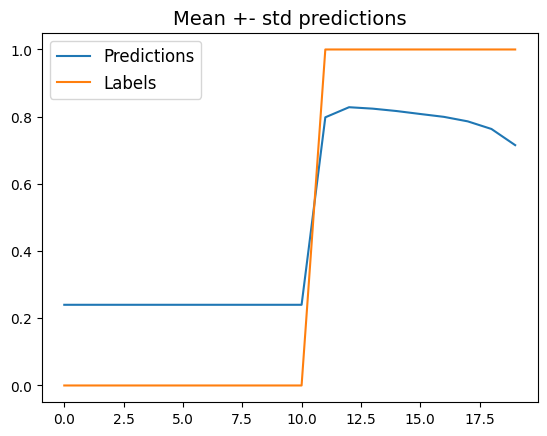

In [14]:
from utils.visualize import visualize_predictions
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=True)

seq_batch, labels_batch = next(iter(test_dataloader))

visualize_predictions(
    bce_model_custom_noisy_adam,
    "seq2seq",
    seq_batch,
    labels_batch,
    n_pics=10
)

In [19]:
args_config["learning"]["lr"] = 1e-3
args_config["learning"]["temperature"] = 0.001

# for ABAnnealingLR
args_config["learning"]["final_lr"] = 1e-4
args_config["learning"]["gamma"] = 0.5
args_config["learning"]["T_max"] = 50000

threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

for seed in range(10):
    core_model = core_models.BaseRnn(
        input_size=args_config["model"]["input_size"],
        hidden_dim=args_config["model"]["hidden_dim"],
        n_layers=args_config["model"]["n_layers"],
        drop_prob=args_config["model"]["drop_prob"],
        layer_norm=args_config["model"]["layer_norm"]
    )

    bce_model_custom_noisy_adam = CPDModelCustomNoisyAdam(
        loss_type="bce",
        args=args_config,
        model=core_model,
        train_dataset=train_dataset,
        test_dataset=test_dataset
    )

    logger = CometLogger(
        save_dir='logs/bce/sgld',
        api_key='agnHNC2vEt7tOxnnxT4LzYf7Y',
        project_name='cpd-with-uncertainty',
        workspace='stalex2902',
        experiment_name=f'BCE-CustomNoisyAdam_seed_{seed}',
        display_summary_level=0
    )

    trainer = pl.Trainer(
        max_epochs=100,
        gpus=1,
        benchmark=True,
        check_val_every_n_epoch=1,
        gradient_clip_val=0.,
        logger=logger,
        # use early stopping
        #callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
    )

    trainer.fit(bce_model_custom_noisy_adam)
    
    loss_type = "bce"
    path_to_folder = "saved_models/bce/human_activity/sgld_adam/"

    path = (
        path_to_folder
        + "/"
        + args_config["experiments_name"]
        + "_loss_type_"
        + str(loss_type)
        + "sgld_adam_"
        + "_model_num_"
        + str(seed)
        + ".pth"
    )
    
    torch.save(bce_model_custom_noisy_adam.state_dict(), path)

    # compute metrics
    metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = evaluation_pipeline(
        bce_model_custom_noisy_adam,
        bce_model_custom_noisy_adam.val_dataloader(),
        threshold_list,
        device="cpu", # choose 'cpu' or 'cuda' if available
        model_type="seq2seq",
        verbose=False,
        margin_list=[1, 2, 4]
    )
    
    timestamp = datetime.now().strftime("%y%m%dT%H%M%S")
    
    write_metrics_to_file(
        filename="results/bce/har/sgld_adam/BCE_single_sgld_adam.txt",
        metrics=(metrics, (max_th_f1_margins_dict, max_f1_margins_dic)),
        seed=seed,
        timestamp=timestamp,
        comment="Single model, default params",
    )

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/7a6fdcaf2a2547d6a205347058647441



COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 62.5852
Time to FA 7.255, delay detection 0.6417 for best-F1 threshold: 0.4745
TN 23, FP 418, FN 72, TP 824 for best-F1 threshold: 0.4745
Max F1 0.7708: for best-F1 threshold 0.4745
COVER 0.8986: for best-F1 threshold 0.4745
Max COVER 0.8986: for threshold 0.4745
Max F1 with margin 1: 0.7737 for best threshold 0.4745
Max F1 with margin 2: 0.7805 for best threshold 0.4745
Max F1 with margin 4: 0.7917 for best threshold 0.4745


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/9079109012064603be2e8cc5d9fd6df3



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 76.4777
Time to FA 7.2924, delay detection 2.0456 for best-F1 threshold: 0.4745
TN 18, FP 570, FN 244, TP 505 for best-F1 threshold: 0.4745
Max F1 0.5537: for best-F1 threshold 0.4745
COVER 0.7887: for best-F1 threshold 0.4745
Max COVER 0.7887: for threshold 0.4745
Max F1 with margin 1: 0.5425 for best threshold 0.4745
Max F1 with margin 2: 0.5632 for best threshold 0.4745
Max F1 with margin 4: 0.5968 for best threshold 0.4745


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/5850cfec8bb24d3e97a1d4e5ed119c93



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 79.3999
Time to FA 11.4503, delay detection 4.2827 for best-F1 threshold: 0.5255
TN 121, FP 380, FN 494, TP 342 for best-F1 threshold: 0.5255
Max F1 0.439: for best-F1 threshold 0.5255
COVER 0.7127: for best-F1 threshold 0.5255
Max COVER 0.7127: for threshold 0.5255
Max F1 with margin 1: 0.1878 for best threshold 0.5255
Max F1 with margin 2: 0.2579 for best threshold 0.5255
Max F1 with margin 4: 0.44 for best threshold 0.5255


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/63e1ad30bc2840e0890322691dfb4c73



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 56.2412
Time to FA 11.5505, delay detection 2.6365 for best-F1 threshold: 0.4745
TN 132, FP 280, FN 274, TP 651 for best-F1 threshold: 0.4745
Max F1 0.7015: for best-F1 threshold 0.4745
COVER 0.8143: for best-F1 threshold 0.4745
Max COVER 0.8341: for threshold 0.4241
Max F1 with margin 1: 0.6685 for best threshold 0.4745
Max F1 with margin 2: 0.6966 for best threshold 0.4745
Max F1 with margin 4: 0.7302 for best threshold 0.4745


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/62b9c08359874a198619249900259f79



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 1 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 86.5398
Time to FA 6.6657, delay detection 2.6956 for best-F1 threshold: 0.5255
TN 19, FP 727, FN 320, TP 271 for best-F1 threshold: 0.5255
Max F1 0.3411: for best-F1 threshold 0.5255
COVER 0.715: for best-F1 threshold 0.5255
Max COVER 0.715: for threshold 0.5255
Max F1 with margin 1: 0.2497 for best threshold 0.5255
Max F1 with margin 2: 0.3432 for best threshold 0.5255
Max F1 with margin 4: 0.4015 for best threshold 0.5255


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/565c7d0537e0422db6ca3fcf9b219f96



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 84.6062
Time to FA 16.8878, delay detection 7.0763 for best-F1 threshold: 0.5255
TN 120, FP 96, FN 929, TP 192 for best-F1 threshold: 0.5255
Max F1 0.2725: for best-F1 threshold 0.5255
COVER 0.7186: for best-F1 threshold 0.5255
Max COVER 0.7186: for threshold 0.5255
Max F1 with margin 1: 0.2725 for best threshold 0.5255
Max F1 with margin 2: 0.2725 for best threshold 0.5255
Max F1 with margin 4: 0.2725 for best threshold 0.5255


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/3216228ee5034f17accd32a90e1f7557



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 65.4355
Time to FA 11.4996, delay detection 2.7599 for best-F1 threshold: 0.4745
TN 119, FP 315, FN 249, TP 654 for best-F1 threshold: 0.4745
Max F1 0.6987: for best-F1 threshold 0.4745
COVER 0.7964: for best-F1 threshold 0.4745
Max COVER 0.7964: for threshold 0.4745
Max F1 with margin 1: 0.6032 for best threshold 0.4745
Max F1 with margin 2: 0.6549 for best threshold 0.4745
Max F1 with margin 4: 0.7111 for best threshold 0.4745


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/9468b55bee6f416daef13a9747260cc7



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 89.128
Time to FA 0.0, delay detection 0.0 for best-F1 threshold: -0.001
TN 0, FP 1313, FN 0, TP 24 for best-F1 threshold: -0.001
Max F1 0.0353: for best-F1 threshold -0.001
COVER 0.6668: for best-F1 threshold -0.001
Max COVER 0.6668: for threshold -0.001
Max F1 with margin 1: 0.0818 for best threshold -0.001
Max F1 with margin 2: 0.1301 for best threshold -0.001
Max F1 with margin 4: 0.2466 for best threshold -0.001


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/34bd7394c39141c190d6e8668c449a7f



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
TN: 172, FP: 0, FN: 1165, TP: 0, DELAY:8.902767181396484, FP_DELAY:20.0, COVER: 0.6667726252804786
AUC: 55.4671
Time to FA 9.0524, delay detection 1.0352 for best-F1 threshold: 0.4745
TN 66, FP 438, FN 72, TP 761 for best-F1 threshold: 0.4745
Max F1 0.749: for best-F1 threshold 0.4745
COVER 0.834: for best-F1 threshold 0.4745
Max COVER 0.834: for threshold 0.4745
Max F1 with margin 1: 0.7149 for best threshold 0.4745
Max F1 with margin 2: 0.7533 for best threshold 0.4745
Max F1 with margin 4: 0.8004 for best threshold 0.4745


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/3d709bb5b02b45d89a9a701813ac5c9f



COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Uploading 2 metrics, params and output messages


Collectting model's outputs
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, COVER: 0.6667726252804786
TN: 0, FP: 1313, FN: 0, TP: 24, DELAY:0.0, FP_DELAY:0.0, CO

In [13]:
args_config

{'model': {'hidden_dim': 8,
  'input_size': 28,
  'n_layers': 1,
  'drop_prob': 0.5,
  'layer_norm': False},
 'learning': {'batch_size': 64,
  'lr': 0.001,
  'epochs': 100,
  'grad_clip': 0.0,
  'gpus': 1},
 'loss': {'T': 5},
 'early_stopping': {'monitor': 'val_loss', 'min_delta': 0, 'patience': 10},
 'experiments_name': 'human_activity',
 'model_type': 'seq2seq',
 'loss_type': 'bce',
 'num_workers': 2}

In [35]:
args_config["learning"]["lr"] = 1e-3
args_config["learning"]["temperature"] = 0.001

# for ABAnnealingLR
args_config["learning"]["final_lr"] = 1e-4
args_config["learning"]["gamma"] = 0.5
args_config["learning"]["T_max"] = 50000
#args_config["learning"]["last_epoch"] = -1

core_model = core_models.BaseRnn(
    input_size=args_config["model"]["input_size"],
    hidden_dim=args_config["model"]["hidden_dim"],
    n_layers=args_config["model"]["n_layers"],
    drop_prob=args_config["model"]["drop_prob"],
    layer_norm=args_config["model"]["layer_norm"]
)

bce_model_custom_noisy_adam = CPDModelCustomNoisyAdam(
    loss_type="bce",
    args=args_config,
    model=core_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

logger = CometLogger(
    save_dir='logs/bce/sgld',
    api_key='agnHNC2vEt7tOxnnxT4LzYf7Y',
    project_name='cpd-with-uncertainty',
    workspace='stalex2902',
    experiment_name='BCE-CustomNoisyAdam_ABAnnealing_HAR_temp_0.001_final_lr_1e-4',
    display_summary_level=0
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    # use early stopping
    #callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer.fit(bce_model_custom_noisy_adam)

CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type    | Params
----------------------------------
0 | model | BaseRnn | 1.2 K 
1 | loss  | BCELoss | 0     
----------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/stalex2902/cpd-with-uncertainty/6d6aec3c70934a509a445eeed9bbb930

COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


COMET WARNING: Failed to log system metrics: [sys.ram,sys.cpu,sys.load]


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 1 metrics, params and output messages


In [1]:
threshold_number = 50
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
_ = metrics.evaluation_pipeline(
    bce_model_custom_noisy_adam,
    bce_model_custom_noisy_adam.val_dataloader(),
    threshold_list,
    device="cpu", # choose 'cpu' or 'cuda' if available
    model_type="seq2seq",
    verbose=True,
    margin_list=[1, 2, 4]
)

NameError: name 'np' is not defined

# Explosion

In [14]:
SEED = 0
fix_seeds(SEED)

model_type = "seq2seq"

experiments_name = "explosion"

path_to_config = "configs/" + "video" + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type

args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1

args_config["learning"]["epochs"] = 100

In [15]:
train_dataset, test_dataset = CPDDatasets(experiments_name).get_dataset_()
train_dataset[0][0].shape

torch.Size([3, 16, 256, 256])

In [16]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [17]:
args_config["learning"]["lr"] = 1e-3
args_config["learning"]["temperature"] = 0.001

# for ABAnnealingLR
args_config["learning"]["final_lr"] = 1e-4
args_config["learning"]["gamma"] = 0.5
args_config["learning"]["T_max"] = 50000

core_model = core_models.CombinedVideoRNN(
    input_dim=args_config["model"]["input_size"],
    rnn_hidden_dim=args_config["model"]["hidden_rnn"],
    num_layers=args_config["model"]["rnn_n_layers"],
    rnn_dropout=args_config["model"]["rnn_dropout"],
    dropout=args_config["model"]["dropout"],
    layer_norm=args_config["model"]["layer_norm"]
)

bce_sgld_model = CPDModelCustomNoisyAdam(
    loss_type="bce",
    args=args_config,
    model=core_model,
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

In [ ]:
logger = CometLogger(
    save_dir='logs/bce/sgld',
    api_key='agnHNC2vEt7tOxnnxT4LzYf7Y',
    project_name='cpd-with-uncertainty',
    workspace='stalex2902',
    experiment_name=f'BCE-SGLD_Explosion_seed_{SEED}',
    display_summary_level=0
)

trainer = pl.Trainer(
    max_epochs=100,
    gpus=1,
    benchmark=True,
    check_val_every_n_epoch=1,
    gradient_clip_val=0.,
    logger=logger,
    # use early stopping
    #callbacks=EarlyStopping(monitor="val_loss", min_delta=0, patience=10)
)

trainer.fit(bce_sgld_model)

In [19]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]


In [22]:
_ = evaluation_pipeline(
    bce_sgld_model,
    bce_sgld_model.val_dataloader(),
    threshold_list,
    device="cuda", # choose 'cpu' or 'cuda' if available
    model_type="seq2seq",
    verbose=True,
    margin_list=[1, 2, 4]
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

## BCE-SGLD Ensemble

In [23]:
from utils.metrics import evaluation_pipeline, write_metrics_to_file
from utils.ensembles import EnsembleCPDModel

In [19]:
ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list("saved_models/bce/explosion/sgld_adam")

In [21]:
threshold_number = 100
threshold_list = np.linspace(-5, 5, threshold_number)
threshold_list = 1 / (1 + np.exp(-threshold_list))
threshold_list = [-0.001] + list(threshold_list) + [1.001]

seed = 0

# compute metrics
metrics, (max_th_f1_margins_dict, max_f1_margins_dic), _, _ = metrics.evaluation_pipeline(
    ens_bce,
    test_dataloader,
    threshold_list,
    device="cuda", # choose 'cpu' or 'cuda' if available
    model_type="ensemble",
    verbose=True,
    margin_list=[1, 2, 4]
)

  0%|          | 0/20 [00:00<?, ?it/s]

Collectting model's outputs


100%|██████████| 20/20 [02:43<00:00,  8.18s/it]


TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0, DELAY:0.0, FP_DELAY:0.0, COVER: 0.9806299603174603
TN: 0, FP: 315, FN: 0, TP: 0

In [25]:
timestamp = datetime.now().strftime("%y%m%dT%H%M%S")

In [26]:
write_metrics_to_file(
    filename="results/bce/explosion/sgld_adam/BCE_sgld_adam_ensemble.txt",
    metrics=(metrics, (max_th_f1_margins_dict, max_f1_margins_dic)),
    seed=0,
    timestamp=timestamp,
    comment="BCE-SGLD Ensemble model, default params",
)